In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import io
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import svm

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/task.csv')

In [ ]:
train.shape

(32561, 15)

In [ ]:
train

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [ ]:
train = train.replace('?', np.nan)

In [ ]:
train.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [ ]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

It might be useful to check the correlation before starting out just to get an idea about the effect each feature has on other features and the target  

In [ ]:
train.corr()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education.num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital.gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital.loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours.per.week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


In [ ]:
train['income']=train['income'].astype('category').cat.codes


From The correlation matrix below we find that there in no relation between fnlwgt and the income so this column should be removed

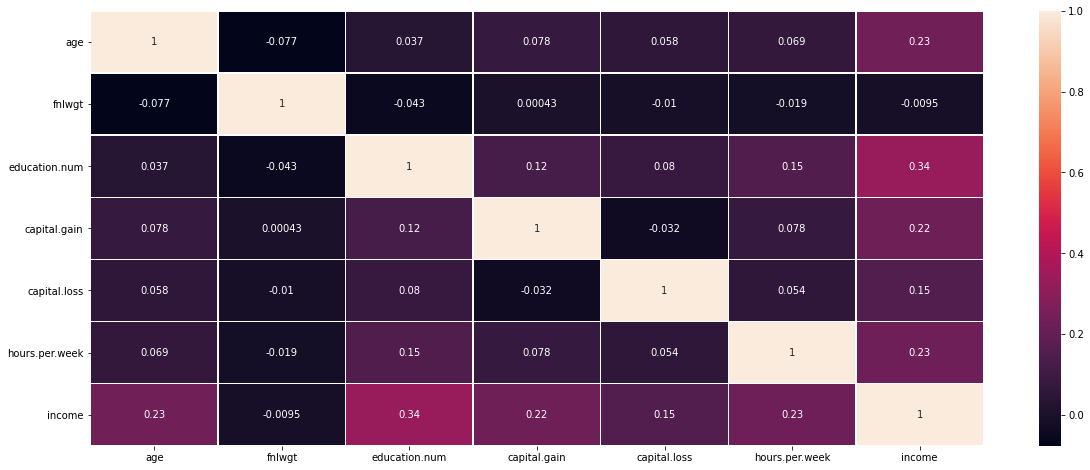

In [ ]:
corr = train.corr()
f, ax = plt.subplots(figsize=(20, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,linewidths=.5, annot= True)

Note that this table only shows the correlation between features of data type int, so it is necessary to enumerate the columns of object type in order to check for their correlation between the target column(Income).

Transform the values of the income class to 0 and 1 so that 0 represent income <=50k and 1 for income >50k

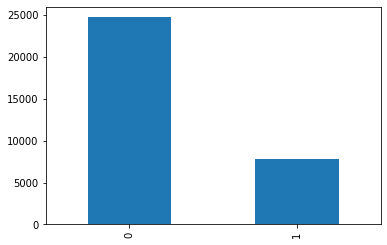

In [ ]:
fig, ax = plt.subplots()
train['income'].value_counts().plot(ax=ax, kind='bar')

**Data Cleaning**

**1-Age**


In [ ]:
train['age'].unique()

array([90, 82, 66, 54, 41, 34, 38, 74, 68, 45, 52, 32, 51, 46, 57, 22, 37,
       29, 61, 21, 33, 49, 23, 59, 60, 63, 53, 44, 43, 71, 48, 73, 67, 40,
       50, 42, 39, 55, 47, 31, 58, 62, 36, 72, 78, 83, 26, 70, 27, 35, 81,
       65, 25, 28, 56, 69, 20, 30, 24, 64, 75, 19, 77, 80, 18, 17, 76, 79,
       88, 84, 85, 86, 87])

In [ ]:
print('min value for age is: ',train['age'].min(), ',while the max value is: ', train['age'].max())

min value for age is:  17 ,while the max value is:  90


In [ ]:
train.isnull().sum()


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

Let's see if we can divide the ages into age groups and deduce something from the data. 

In [ ]:
bins = [ 17, 25, 35, 50, 65, np.inf]
names = ['17-25', '25-35', '35-50', '50-65', '65+']
train['AgeRange'] = pd.cut(train['age'], bins, labels=names)
NumberedAgeCategories = {'17-25':0 , '25-35':1, '35-50':2, '50-65':3,'65+':4}
train['AgeRange']=train['AgeRange'].map(NumberedAgeCategories)  
train['AgeRange']=pd.to_numeric(train['AgeRange'])
train['AgeRange'].fillna(0,inplace = True)


In [ ]:
corr = train.corr()
print("Correlation between the new feature' Age Range' is "+"{:.2f}".format(corr['income']['AgeRange']), ', while correlation between income and age is '+"{:.2f}".format(corr['income']['age']))

Correlation between the new feature' Age Range' is 0.25 , while correlation between income and age is 0.23


It seems that AgeRange is doing slightly better than the age feature. 

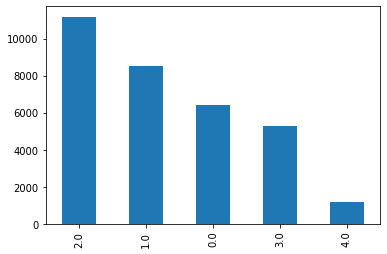

In [ ]:
fig, ax = plt.subplots()
train['AgeRange'].value_counts().plot(ax=ax, kind='bar')

We can deduce from this plot that the most common age in this dataset is in category 3 which is between the age of 35 and 50, while the smallest category is 5 which belongs to people aged 65 and above. 

**2- Workclass**

In [ ]:
train['workclass'].value_counts() 

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

Checking for the percentage of missing data for this feature:

In [ ]:
nullValues= train['workclass'].isnull().sum()
total= train.shape[0]
print('Percentage of null values is '+"{:.2f}".format(nullValues/total*100)+'%')

Percentage of null values is 5.64%


The percentage can be considered significant since it above 5% so it might be safer to turn the cells with null values into a separate new category. 

Here is a representation to get an idea about the frequency of each working class: 

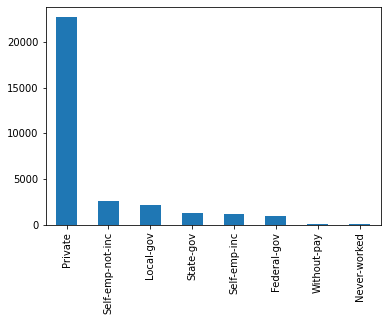

In [ ]:
fig, ax = plt.subplots()
train['workclass'].value_counts().plot(ax=ax, kind='bar')

Encoding object types is a necessary step for modelling which we will go through later: 

In [ ]:
train['workclass']=train['workclass'].replace(np.nan, 0)

In [ ]:
train

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,AgeRange
0,90,0,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0,4.0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,4.0
2,66,0,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0,4.0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,3.0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0,0.0
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,1.0
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,2.0
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,3.0


In [ ]:
train['workclass']= train.workclass.map({
0                 :0,             
'Private'         :1,
'Self-emp-not-inc':2,
'Local-gov'       :3,
'State-gov'       :4,
'Self-emp-inc'    :5,
'Federal-gov'     :6,
'Without-pay'     :7,
'Never-worked'    :8
})


**3- fnlwgt**


> final weight : number of units in the target population that the responding unit represents.

In [ ]:
train['fnlwgt'].unique()

array([ 77053, 132870, 186061, ...,  34066,  84661, 257302])

In [ ]:
train['fnlwgt'].min()

12285

In [ ]:
train['fnlwgt'].max()

1484705

<Figure size 3600x720 with 0 Axes>

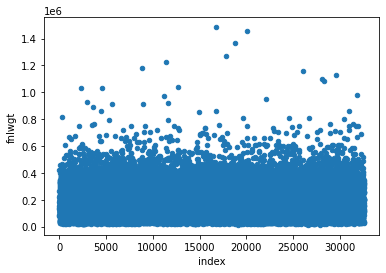

In [ ]:
plt.figure(figsize=(50,10))
train.reset_index().plot(kind='scatter', x='index', y='fnlwgt')

Text(0, 0.5, 'Final Weight')

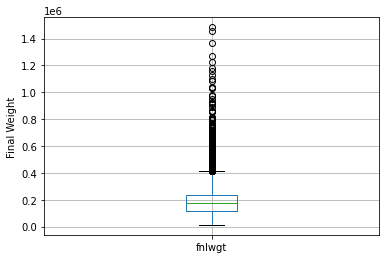

In [ ]:
fig = train.boxplot(column='fnlwgt')
fig.set_title('')
fig.set_ylabel('Final Weight')

remove outliers in the the data because they only account for 2% of the whole dataset:

In [ ]:
train.drop(train[train['fnlwgt']>0.42*1e6].index, inplace = True)

**4- Education & Education.num**

There are no null vallues in this column so we can start analysing it immdeiately.

In [ ]:
train['education'].value_counts()

HS-grad         10196
Some-college     7086
Bachelors        5209
Masters          1680
Assoc-voc        1356
11th             1139
Assoc-acdm       1039
10th              895
7th-8th           627
Prof-school       570
9th               489
12th              414
Doctorate         399
5th-6th           313
1st-4th           155
Preschool          47
Name: education, dtype: int64

Education.num : the highest level of education achieved in numerical form.

In [ ]:
educationKeyValues = dict(zip(train['education'], train['education.num']))

In [ ]:
educationKeyValues = sorted(educationKeyValues.items(), key=lambda x: x[1], reverse=False)

In [ ]:
educationKeyValues

[('Preschool', 1),
 ('1st-4th', 2),
 ('5th-6th', 3),
 ('7th-8th', 4),
 ('9th', 5),
 ('10th', 6),
 ('11th', 7),
 ('12th', 8),
 ('HS-grad', 9),
 ('Some-college', 10),
 ('Assoc-voc', 11),
 ('Assoc-acdm', 12),
 ('Bachelors', 13),
 ('Masters', 14),
 ('Prof-school', 15),
 ('Doctorate', 16)]

Order of education levels based on education.num: 

Preschool < 1st-4th < 5th-6th < 7th-8th < 9th < 10th < 11th < 12th < HS-grad < Prof-school < Assoc-acdm < Assoc-voc < Some-college < Bachelors < Masters < Doctorate

Here's the same type of plot used previously just to get an idea about the distribution of categroies: 

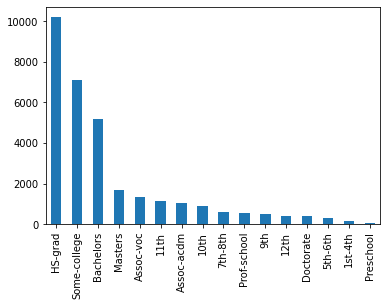

In [ ]:
fig, ax = plt.subplots()
train['education'].value_counts().plot(ax=ax, kind='bar')

It is clear that most of the individuals in this dataset were atleast High school graduates. 

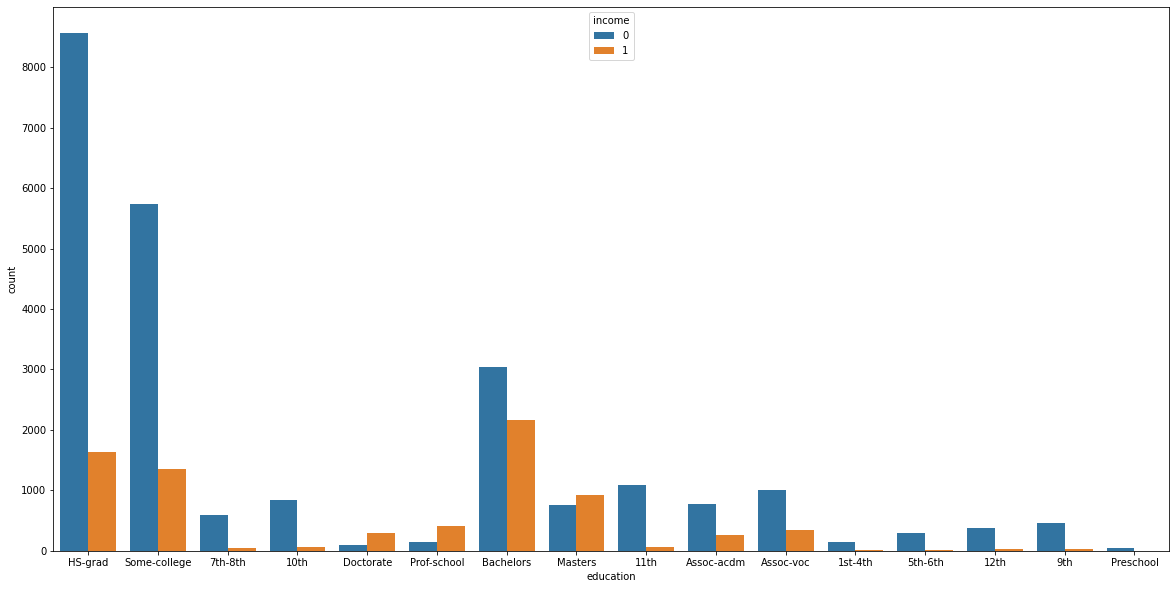

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x="education", hue="income", data=train)

We can deduce from this graph that most people with an education level below Masters, earn less than 50k, with the exception of Prof-school. 
A larger number of those who have Masters/ phd earn more than 50k.

Since education.num already maps education, we can remove the education column and rely on this dictionary d to provide us with the key of the corresponding value if we needed to restore the education level later : 

In [ ]:
train.drop('education',axis='columns', inplace=True)

**5-martial-status**

Married-civ-spouse    : spouce is civilian

Never-married         : Single people never married

Divorced              : were married and legellay   seperated     

Separated             : similar to divorced but not legally     

Widowed               : husband or wife died     

Married-spouse-absent : married people living-apart    

Married-AF-spouse     : Spouse works in the air force    





In [ ]:
print((train['marital.status'].value_counts()))

print('Total categories',len(train['marital.status'].value_counts()))



Married-civ-spouse       14564
Never-married            10323
Divorced                  4333
Separated                  989
Widowed                    978
Married-spouse-absent      406
Married-AF-spouse           21
Name: marital.status, dtype: int64
Total categories 7


From the bar-plot distribution and meaning of each category we we can divide the categories into 3 categories as the other 4 categories dont have alot of data and can be sub-categories of the other 3

Married:Married-civ-spouse,Married-AF-spouse 

Not_married: Never-married,Married-spouse-absent 

Seperated:Divorced,separated,Widowed



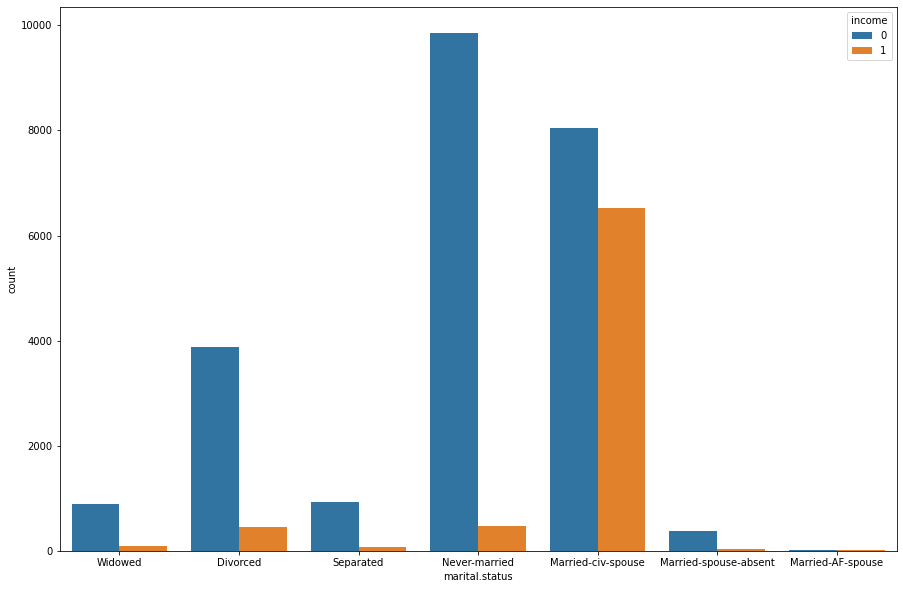

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(data = train, x ='marital.status',hue='income')

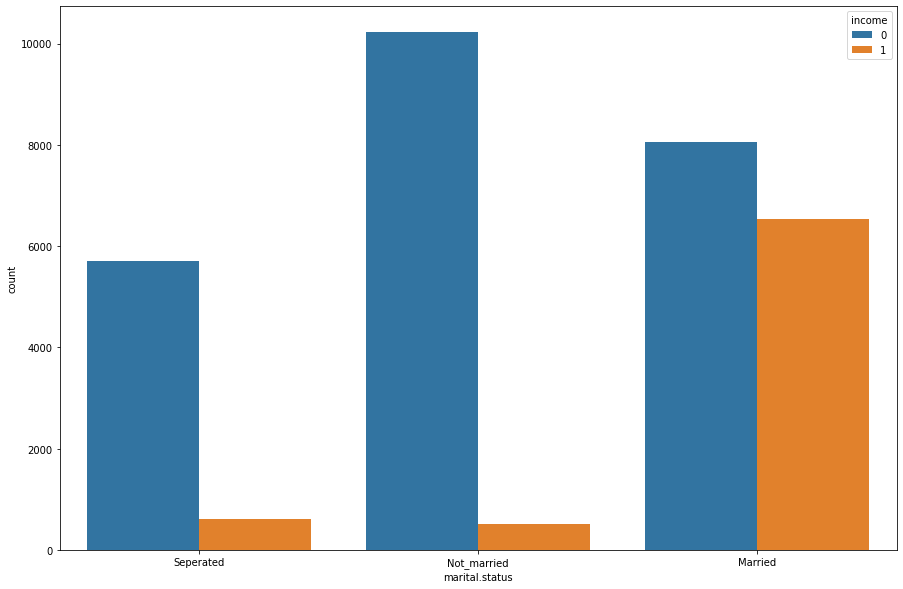

In [ ]:
train['marital.status'].replace(
    {
      'Married-civ-spouse':'Married',
      'Never-married':'Not_married',
      'Divorced':'Seperated',
      'Separated':'Seperated',
      'Widowed':'Seperated',
      'Married-spouse-absent':'Not_married',
      'Married-AF-spouse':'Married'
    },
    inplace=True
)
plt.figure(figsize=(15,10))
sns.countplot(data = train, x ='marital.status',hue='income')

In [ ]:

train['marital.status'] = LabelEncoder().fit_transform(train['marital.status'])


**6-Occupation**

In [ ]:
print((train['occupation'].value_counts()))

print('Total categories',len(train['occupation'].value_counts()))

print('Null values:',train['occupation'].isnull().sum())




Prof-specialty       4044
Craft-repair         3976
Exec-managerial      3957
Adm-clerical         3669
Sales                3545
Other-service        3193
Machine-op-inspct    1949
Transport-moving     1544
Handlers-cleaners    1309
Farming-fishing       961
Tech-support          896
Protective-serv       630
Priv-house-serv       145
Armed-Forces            9
Name: occupation, dtype: int64
Total categories 14
Null values: 1787


In [ ]:
train['occupation']=train['occupation'].replace(np.nan,'NA')
train['occupation']=train['occupation'].astype(str)
train.head()



,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,AgeRange
0,90,0,77053,9,2,NA,Not-in-family,White,Female,0,4356,40,United-States,0,4.0
1,82,1,132870,9,2,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,4.0
2,66,0,186061,10,2,NA,Unmarried,Black,Female,0,4356,40,United-States,0,4.0
3,54,1,140359,4,2,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,3.0
4,41,1,264663,10,2,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,2.0


We can find out that the most who have income more than  50k are Exec-managment and proof-speciality

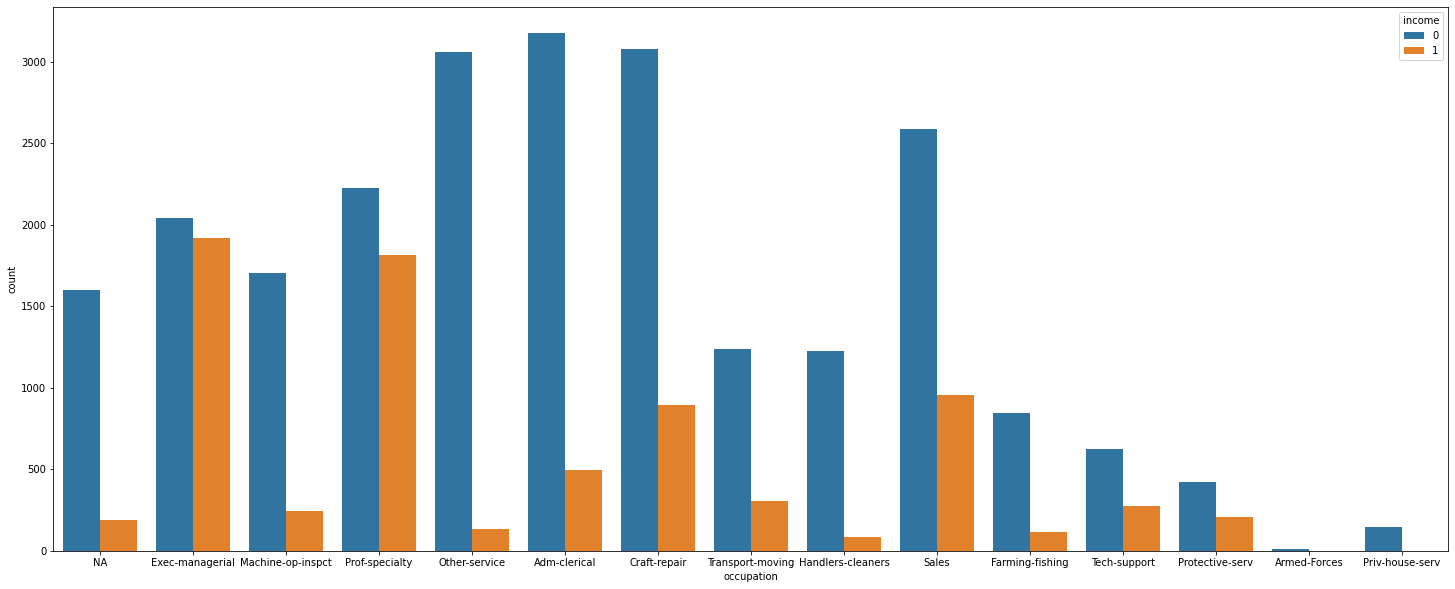

In [ ]:
plt.figure(figsize=(25,10))

sns.countplot(data = train, x ='occupation',hue='income')

In [ ]:
train['occupation'] = LabelEncoder().fit_transform(train['occupation'])
train.head()


,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,AgeRange
0,90,0,77053,9,2,7,Not-in-family,White,Female,0,4356,40,United-States,0,4.0
1,82,1,132870,9,2,3,Not-in-family,White,Female,0,4356,18,United-States,0,4.0
2,66,0,186061,10,2,7,Unmarried,Black,Female,0,4356,40,United-States,0,4.0
3,54,1,140359,4,2,6,Unmarried,White,Female,0,3900,40,United-States,0,3.0
4,41,1,264663,10,2,10,Own-child,White,Female,0,3900,40,United-States,0,2.0


**7- Realtionship**

In [ ]:
print((train['relationship'].value_counts()))

print('relationship',len(train['relationship'].value_counts()))


Husband           12828
Not-in-family      8061
Own-child          4916
Unmarried          3341
Wife               1529
Other-relative      939
Name: relationship, dtype: int64
relationship 6


we can find that most who have high salary are married men which is similar to the results from the marital status countplot

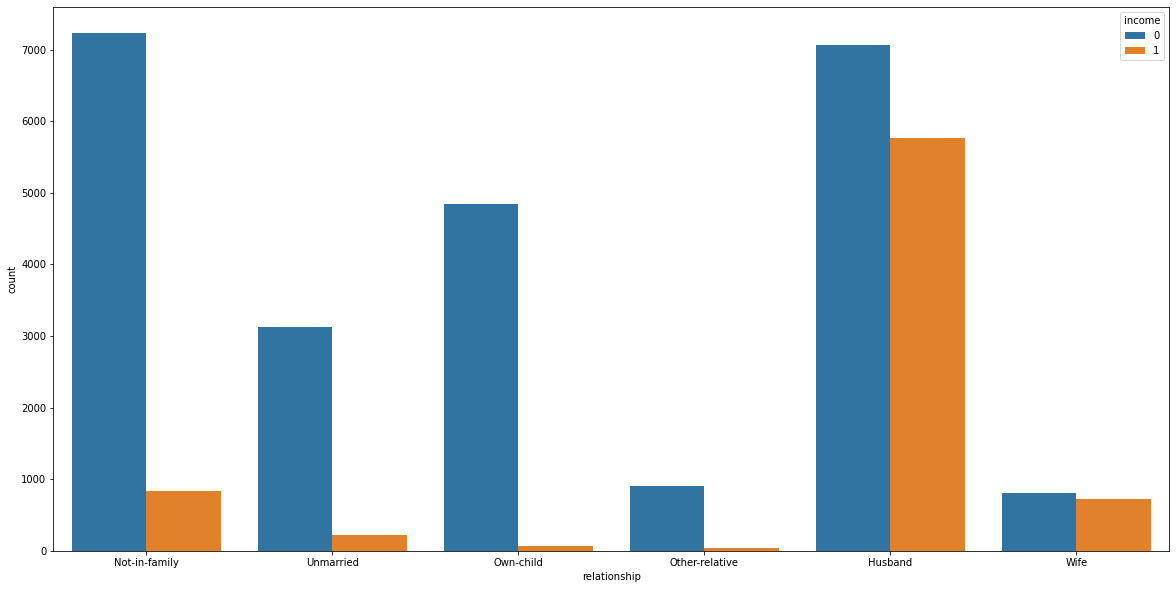

In [ ]:
plt.figure(figsize=(20,10))

sns.countplot(data=train,x='relationship',hue='income')

In [ ]:
train['relationship'] = LabelEncoder().fit_transform(train['relationship'])
train.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,AgeRange
0,90,0,77053,9,2,7,1,White,Female,0,4356,40,United-States,0,4.0
1,82,1,132870,9,2,3,1,White,Female,0,4356,18,United-States,0,4.0
2,66,0,186061,10,2,7,4,Black,Female,0,4356,40,United-States,0,4.0
3,54,1,140359,4,2,6,4,White,Female,0,3900,40,United-States,0,3.0
4,41,1,264663,10,2,10,3,White,Female,0,3900,40,United-States,0,2.0


The doesnt seem to be a good correlation between both attributes so they both should be kept


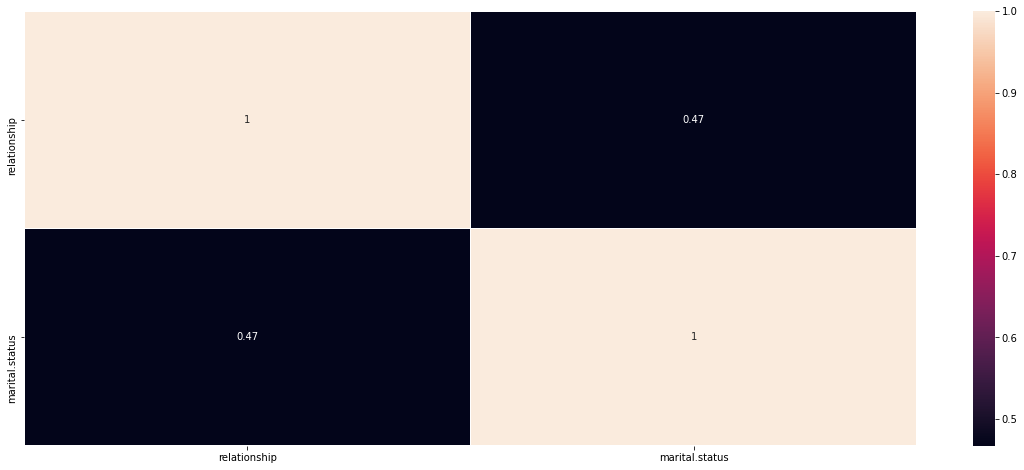

In [ ]:


corr = train[['relationship','marital.status']].corr()
f, ax = plt.subplots(figsize=(20, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,linewidths=.5, annot= True)


**8- Capital loss and gain**

these two features are linked to each other and that's why I'm exploring both of them at the same time.

the capital gain:  basically when someone decides to so sell anything so the amount of money they sold the thing for minus the amount of money they spent on buying it before is the capital gain.

the capital loss: it's exactly the opposite of the capital gain but in this case the amount of money they spent on buying a thing is more than what they got for selling it

both features have 0 nan values

In [ ]:
train['capital.gain'].isna().sum()

0

In [ ]:
train['capital.loss'].isna().sum()

0

the capital loss is more cocise than the gain but we can combine both of them to get the capital net which may does a better job than both of them individually

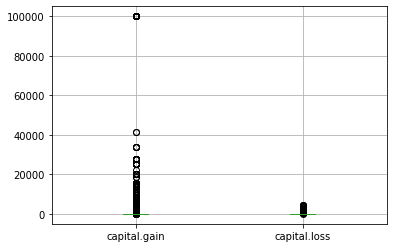

In [ ]:
fig, ax = plt.subplots()
train.boxplot(column = ['capital.gain', 'capital.loss'],ax =ax)

the capital net is the amount they gained minus what they lost

In [ ]:
train['capital.net'] = train['capital.gain']- train['capital.loss']

we have 210 different values in the capital net so we can divide them into 7 bins with 30 values in each bin

In [ ]:
len(train['capital.net'].unique())

210

In [ ]:
cap = train['capital.net'].unique()
lis = sorted(cap)
i=0
bins = []
while i<len(lis):
    bins = bins + [lis[i]]
    i+=30
bins = bins + [np.inf]

i=0
names = []
while i < len(bins)-2:
    names = names + [str(bins[i]) + ' : '+str(bins[i+1])]
    i+=1
names = names + [str(bins[-2])+'+']
names

['-4356 : -2174',
 '-2174 : -1669',
 '-1669 : -155',
 '-155 : 2290',
 '2290 : 3471',
 '3471 : 6767',
 '6767+']

In [ ]:
i=0
categories = {}
while(i<len(names)):
    categories[names[i]] = i
    i+=1
categories

{'-155 : 2290': 3,
 '-1669 : -155': 2,
 '-2174 : -1669': 1,
 '-4356 : -2174': 0,
 '2290 : 3471': 4,
 '3471 : 6767': 5,
 '6767+': 6}

we will cut the capital net on=ver the 7 bins and map them to the categories we have

In [ ]:
train['capital.range'] = pd.cut(train['capital.net'], bins, labels=names)
train['capital.range'] = train['capital.range'].map(categories)
train['capital.range'] = pd.to_numeric(train['capital.range'])
train['capital.range'].fillna(0, inplace=True)

we can infer that the third category which has a capital net of -155 : 2290 is the most frequent and most of them belong to <=50k category

and most of the people in the sixth category happen to be in >50k category

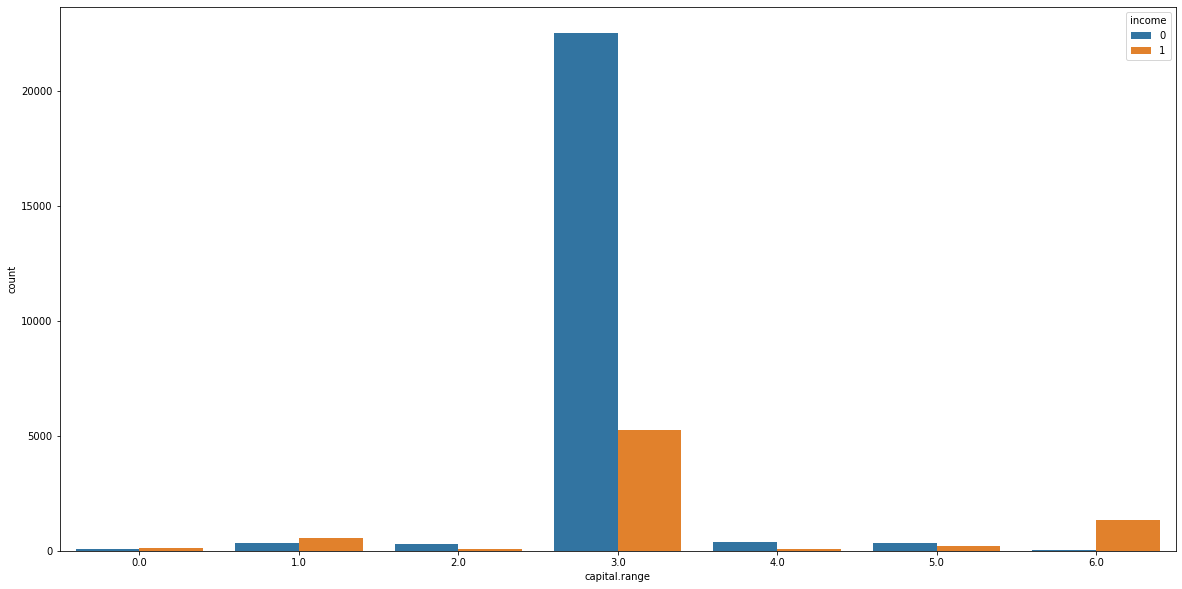

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x="capital.range", hue="income", data=train)

In [ ]:
train.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,AgeRange,capital.net,capital.range
0,90,0,77053,9,2,7,1,White,Female,0,4356,40,United-States,0,4.0,-4356,0.0
1,82,1,132870,9,2,3,1,White,Female,0,4356,18,United-States,0,4.0,-4356,0.0
2,66,0,186061,10,2,7,4,Black,Female,0,4356,40,United-States,0,4.0,-4356,0.0
3,54,1,140359,4,2,6,4,White,Female,0,3900,40,United-States,0,3.0,-3900,0.0
4,41,1,264663,10,2,10,3,White,Female,0,3900,40,United-States,0,2.0,-3900,0.0


In [ ]:
train.corr()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,capital.gain,capital.loss,hours.per.week,income,AgeRange,capital.net,capital.range
age,1.000000,0.137191,-0.067285,0.033854,-0.083962,-0.005345,-0.263184,0.077989,0.055904,0.069195,0.232350,0.956651,0.074679,0.066578
workclass,0.137191,1.000000,-0.034933,0.177509,-0.068290,-0.016543,-0.085562,0.049042,0.034391,0.119644,0.151662,0.144568,0.047002,0.033571
fnlwgt,-0.067285,-0.034933,1.000000,-0.035876,0.010457,-0.000605,0.006034,0.001341,-0.003269,-0.016356,-0.004785,-0.065849,0.001516,0.000713
education.num,0.033854,0.177509,-0.035876,1.000000,-0.087548,0.090259,-0.093853,0.121238,0.080178,0.148797,0.334821,0.045163,0.116460,0.083342
marital.status,-0.083962,-0.068290,0.010457,-0.087548,1.000000,-0.031548,0.467309,-0.069297,-0.065663,-0.154932,-0.377098,-0.093699,-0.065482,-0.067085
occupation,-0.005345,-0.016543,-0.000605,0.090259,-0.031548,1.000000,-0.039830,0.019526,0.011957,0.004671,0.045516,-0.006904,0.018809,0.007326
relationship,-0.263184,-0.085562,0.006034,-0.093853,0.467309,-0.039830,1.000000,-0.057455,-0.060419,-0.250465,-0.250804,-0.268152,-0.053965,-0.046035
capital.gain,0.077989,0.049042,0.001341,0.121238,-0.069297,0.019526,-0.057455,1.000000,-0.031822,0.076278,0.222913,0.078914,0.998505,0.488127
capital.loss,0.055904,0.034391,-0.003269,0.080178,-0.065663,0.011957,-0.060419,-0.031822,1.000000,0.054479,0.151884,0.059595,-0.086412,-0.567623
hours.per.week,0.069195,0.119644,-0.016356,0.148797,-0.154932,0.004671,-0.250465,0.076278,0.054479,1.000000,0.229627,0.101088,0.073052,0.051704


**9- native Country**

the data seems to be skewed to the united states category so there maybe no need to use this column and we will drop it

In [ ]:
train['native.country'].value_counts()

United-States                 28388
Mexico                          554
Philippines                     197
Germany                         134
Canada                          118
Puerto-Rico                     111
India                           100
El-Salvador                      94
Cuba                             94
England                          88
Jamaica                          81
South                            80
China                            75
Italy                            71
Dominican-Republic               70
Vietnam                          67
Poland                           60
Japan                            60
Columbia                         57
Guatemala                        52
Taiwan                           50
Haiti                            44
Iran                             42
Portugal                         37
Nicaragua                        29
Greece                           29
Ecuador                          28
France                      

In [ ]:
train.drop('native.country',axis='columns', inplace=True)

**10- race**

this column consists of 5 race categories. 

most of the values are skewed to one category which is the white but this gap might be acceptable



In [ ]:
train['race'].value_counts()

White                 27078
Black                  2923
Asian-Pac-Islander     1035
Amer-Indian-Eskimo      310
Other                   268
Name: race, dtype: int64

this is nothing can be inferred from the graph because the data is skewed and the correlation is small between the income and the race

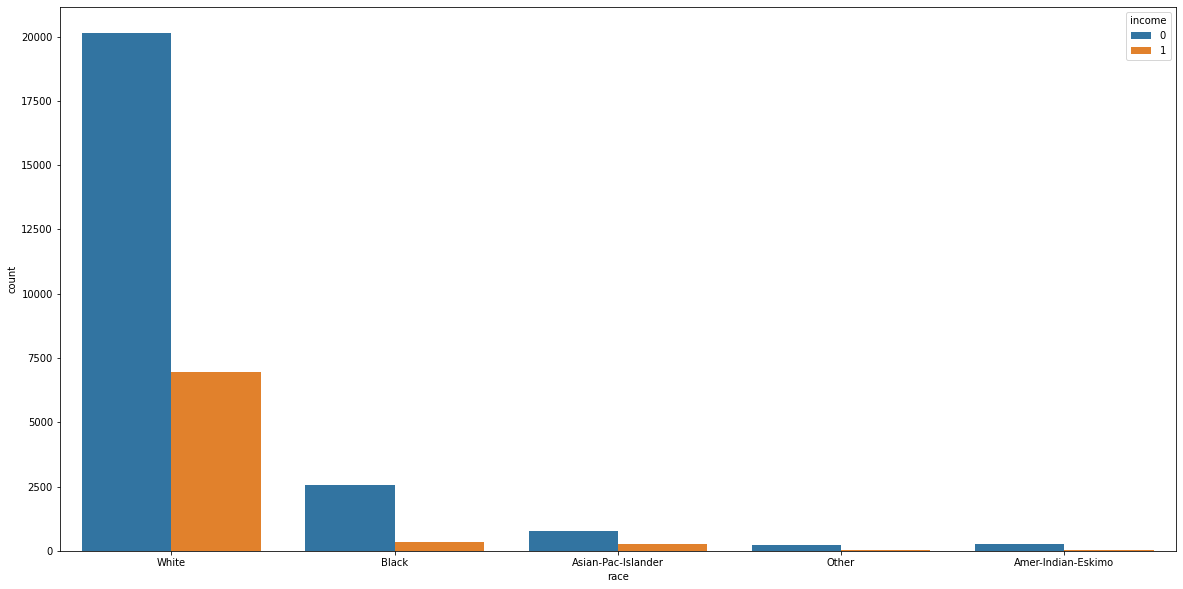

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x="race", hue="income", data=train)

In [ ]:
train['race'] = LabelEncoder().fit_transform(train['race'])

In [ ]:
train.corr()['income']['race']

0.07150712278039872

**11. Sex**

the sex is categorized into the two binary genders and the data is skewed towards the male category but the gap is not considerable

In [ ]:
train['sex'].value_counts()

Male      21104
Female    10510
Name: sex, dtype: int64

the graph says that most of people who earn more than 50 are males and this column might give a glimpse abput the income

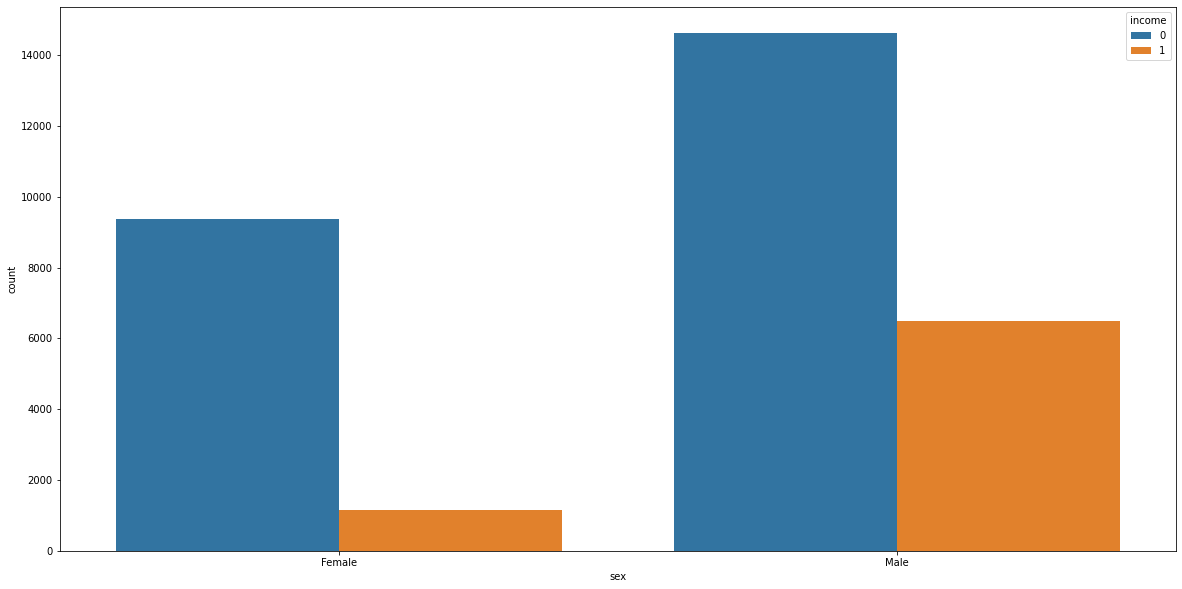

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x="sex", hue="income", data=train)

In [ ]:
train['sex'] = LabelEncoder().fit_transform(train['sex'])

the correlation is significant so we can use this column as a feature

In [ ]:
train.corr()['income']['sex']

0.21751947332001148

**12. hours per week**

this column has a lot of unique values and the range between the minimum and the maximum is signficant compared to the nature of the column which is the hours one works a week

In [ ]:
train['hours.per.week'].unique()

array([40, 18, 45, 20, 60, 35, 55, 76, 50, 42, 25, 32, 90, 48, 15, 70, 52,
       72, 39,  6, 65, 12, 80, 67, 99, 30, 75, 26, 36, 10, 84, 38, 62, 44,
        8, 28, 59,  5, 24, 57, 34, 37, 46, 56, 41, 98, 43, 63,  1, 47, 68,
       54, 16,  9,  3,  4, 33, 23, 22, 64, 51, 19, 58,  2, 53, 96, 66, 21,
        7, 13, 27, 11, 14, 77, 31, 78, 49, 17, 85, 87, 88, 73, 89, 97, 94,
       29, 82, 86, 91, 81, 92, 61, 74, 95])

In [ ]:
print(train['hours.per.week'].min(), train['hours.per.week'].max())

1 99


the boxplot shows a lot of outliers so we might think of grouping them into 5 categories

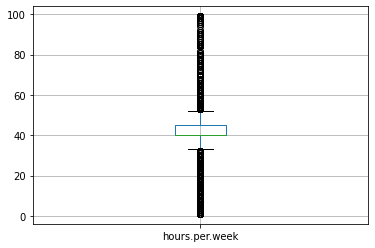

In [ ]:
fig, ax = plt.subplots()
train.boxplot(column = 'hours.per.week',ax =ax)

In [ ]:
bins = [0,20,40,60,80,100]
names = ['0 : 20', '21 : 40', '41 : 60', '61 : 80', '81 : 100']
i=0
categories = {}
while(i<len(names)):
    categories[names[i]] = i
    i+=1
categories

{'0 : 20': 0, '21 : 40': 1, '41 : 60': 2, '61 : 80': 3, '81 : 100': 4}

In [ ]:
train['hours.range'] = pd.cut(train['hours.per.week'], bins, labels=names)
train['hours.range'] = train['hours.range'].map(categories)
train['hours.range'] = pd.to_numeric(train['hours.range'])
train['hours.range'].fillna(0, inplace=True)

In [ ]:
train['hours.range'].value_counts()

1    19426
2     8255
0     2847
3      882
4      204
Name: hours.range, dtype: int64

we can infer that the third category is the one that has the biggest ratio of instances with an income of >50k

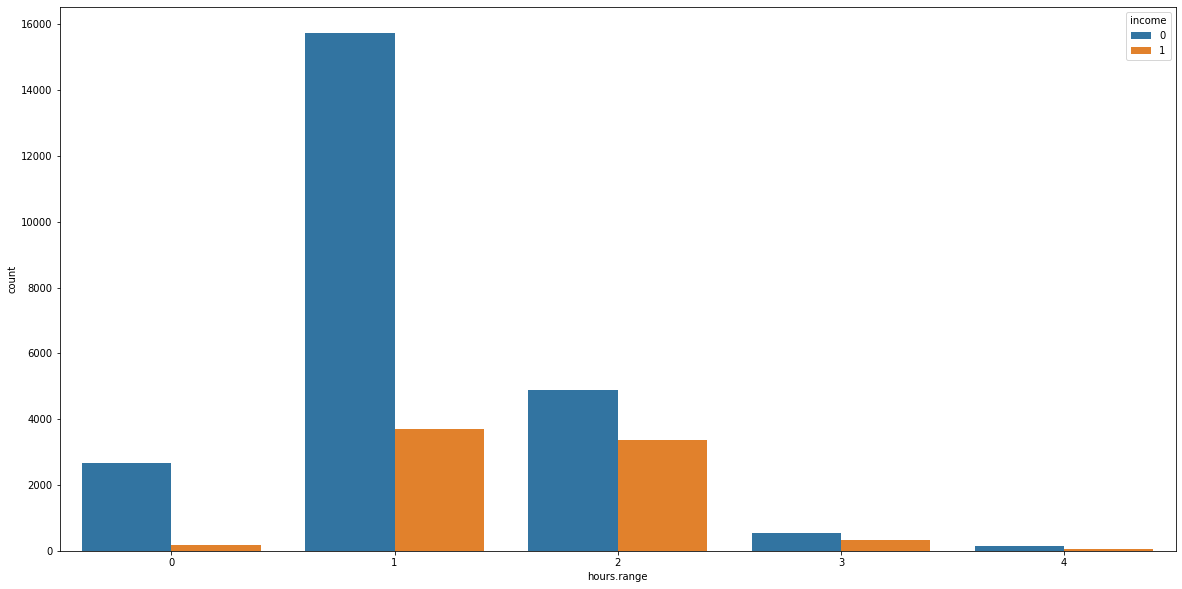

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x="hours.range", hue="income", data=train)

we can find that the correlation of the new column with the income is 0.5 percent more than the old one

In [ ]:
train.corr()['income']['hours.range']

0.23354716504479883

In [ ]:
train.corr()['income']['hours.per.week']

0.22962713909841756

**Model Selection**

checking the data types to ensure that all the features can be used in the model without further processing: 

In [ ]:
train.dtypes

age                 int64
workclass           int64
fnlwgt              int64
education.num       int64
marital.status      int64
occupation          int64
relationship        int64
race                int64
sex                 int64
capital.gain        int64
capital.loss        int64
hours.per.week      int64
income               int8
AgeRange          float64
capital.net         int64
capital.range     float64
hours.range         int64
dtype: object

In [ ]:
X = train.drop('income', axis=1)
y = train['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,random_state=0, test_size = 0.1)

Lets first check what accuracy a dummy classifier will result in: 

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
dummy_majority.score(X_validation, y_validation)

0.7330240404892451

A dummy classifier will result in an accuracy of 73%

We will use grid search to tune hyperparameters to improve model performance. 

In [ ]:
def get_best_model_and_accuracy(model, params, X_train, y_train, X_validation, y_validation):
    grid_clf_auc = GridSearchCV(model,param_grid=params,error_score=0.,scoring = 'roc_auc', cv=3)
    grid_clf_auc.fit(X_train, y_train) # fit the model and parameters
    print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
    print('Grid best score (AUC): ', grid_clf_auc.best_score_)

In [ ]:
def get_best_tree_model_and_accuracy(model, params, X_train, y_train, X_validation, y_validation):
    grid_clf_auc = GridSearchCV(model,param_grid=params,error_score=0.,scoring = 'roc_auc', cv=3)
    grid_clf_auc.fit(X_train, y_train) # fit the model and parameters
    print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
    print('Grid best score (AUC): ', grid_clf_auc.best_score_)
    print('test score (AUC)', roc_auc_score(y_validation, grid_clf_auc.predict_proba(X_validation)[:,1]))

*Trying the Extra Trees model*

In [ ]:
param_grid={'n_estimators':[400, 500,700], 'max_depth':[9,10,15,20],
            'min_samples_split':[2,3,4,5], 'min_samples_leaf':[2,3,4]}
ET= ExtraTreesClassifier(random_state=0) 
get_best_tree_model_and_accuracy(ET, param_grid, X_train, y_train, X_validation, y_validation)

Grid best parameter (max. AUC):  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700}
Grid best score (AUC):  0.9157347589987245
test score (AUC) 0.9205065836237472


further tuning:

In [ ]:
param_grid={'n_estimators':[500,600,700,800], 'max_depth':[20,30,40],
            'min_samples_leaf':[1,2]}
ET= ExtraTreesClassifier(random_state=0, min_samples_split=5) 
get_best_tree_model_and_accuracy(ET, param_grid, X_train, y_train, X_validation, y_validation)

Grid best parameter (max. AUC):  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 600}
Grid best score (AUC):  0.9157059171652415
test score (AUC) 0.9213119254213502


so we end up with a final accuracy of 92% using ExtraTrees with hyperparamteters : n_estimator= 600, maxdepth= 20 and min_samples_leaf of 1.

*trying svm model*

In [ ]:
clf = svm.SVC()
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
get_best_model_and_accuracy(clf, param_grid, X_train, y_train, X_validation, y_validation)

Grid best parameter (max. AUC):  {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Grid best score (AUC):  0.6287723852409666


*trying the random forest classifier model*



In [ ]:
param_grid = {
    'n_estimators': [100,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

rf = RandomForestClassifier(n_jobs=-1)
get_best_tree_model_and_accuracy(rf, param_grid, X_train, y_train, X_validation, y_validation)


Grid best parameter (max. AUC):  {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 1000}
Grid best score (AUC):  0.9128247174549114
test score (AUC) 0.9178146877618951


since the values chosen from the gridsearch of both the n_estimators and the max_depth are the maximum so we should make another gridsearch and increase the parameters with the max features chosen to be sqrt

In [ ]:
param_grid = {
    'n_estimators': [1000, 2000, 3000],
    'max_depth' : [8,9,10,11,12],
}

rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt')
get_best_tree_model_and_accuracy(rf, param_grid, X_train, y_train, X_validation, y_validation)


Grid best parameter (max. AUC):  {'max_depth': 12, 'n_estimators': 1000}
Grid best score (AUC):  0.9171610102677651
test score (AUC) 0.9218318526315409


since again that the parameter chosen were the maximum so we should run another gridsearch and increase the parameters with larger scales

In [ ]:
param_grid = {
    'n_estimators': [ 3000, 50000, 7000],
    'max_depth' : [12,14,16,18],
}

rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt')
get_best_tree_model_and_accuracy(rf, param_grid, X_train, y_train, X_validation, y_validation)


the model has started to overfit on the number of estimators so we should stick back to the last gridsearch and search around it with max depth 14 and around

In [ ]:
param_grid = {
    'n_estimators': [ 3000, 4000, 5000],
    'max_depth' : [11,12,13,14,15],
}

rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt')
get_best_tree_model_and_accuracy(rf, param_grid, X_train, y_train, X_validation, y_validation)


since the max depth is 13 which is in the of the grid so it's our best hyperparameter, however for the number of estimators we can take 4000 + or - 500 to make sure it's our best choice

In [ ]:
param_grid = {
    'n_estimators': [ 3500, 4000, 4500],
}

rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt', max_depth=13)
get_best_tree_model_and_accuracy(rf, param_grid, X_train, y_train, X_validation, y_validation)


another grid search for 4500 + or - 250

In [ ]:
param_grid = {
    'n_estimators': [ 4250, 4500, 4750],
}

rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt', max_depth=13)
get_best_tree_model_and_accuracy(rf, param_grid, X_train, y_train, X_validation, y_validation)


it didn't overfit, so we conclude that the best random forest model have the 3 hyperparameters max_features = sqrt and max_depth = 13 and n_estimators = 4750

**Choosing the best model**

ExtraTrees and RandomForest are the best options for this data as they provide higher accuracy. We will ignore svm since its accuracy is very low on this data and is doing worse than the dummy classifier. ExtraTrees and RandomForest show an increase of around 30% compared to the dummy classifier.

This is a graph that allows us to identify the features that had greater impact on the target column according to these classifiers. 

In [ ]:
rf= rf.fit(X_train, y_train)
arr= dict(zip(X_train.columns,rf.feature_importances_))
data= pd.DataFrame.from_dict(arr,orient='index', columns=['importance'])
features= data.sort_values(['importance'], ascending=False)
features.plot.bar(y="importance", rot=70, title="RandomForest Features with their corresponding importance values")

According to Random Forest, the top three features marital status, education.num and capital.net are the top 3 featurs. 

In [ ]:
ET= ET.fit(X_train, y_train)
arr= dict(zip(X_train.columns,ET.feature_importances_))
data= pd.DataFrame.from_dict(arr,orient='index', columns=['importance'])
features= data.sort_values(['importance'], ascending=False)
features.plot.bar(y="importance", rot=70, title="ExtraTrees Features with their corresponding importance values")

According to ExtraTrees, the top three relevant features are fnlwgt, education.num, and age.

We can conclude the education.num is the feature with a high influence in both classifiers, and hence it is the most important one.


*Trying the neural network model*

In [ ]:
print(X_train.shape)
print(y_train.shape)
print()
print(X_validation.shape)
print(y_validation.shape)


In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import metrics

model = models.Sequential([
                           #layers.Flatten(input_shape = (X_train.shape[0],)),
                           layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.003), input_shape = X_train.shape),
                           layers.Dropout(0.5),
                           layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.003)),
                           layers.Dropout(0.5),
                           layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs=4, batch_size=512, validation_data=(X_validation, y_validation))

print("\nscore on train: "+ str(model.evaluate(X_train,y_train)[1]))
print("score on test: " + str(model.evaluate(X_test,y_test)[1]))

In [ ]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split 


In [ ]:
y_train_NN=train['income'].array;
x_train_NN=train.drop('income',inplace=False,axis=1)
x_train

In [ ]:
y_train_NN=y_train_NN.to_numpy().reshape(len(y_train_NN),1)
print(y_train_NN.shape)
y_train_NN